In [1]:
import os
import json
import time
import requests
import warnings
import pycountry
import pandas as pd
from bs4 import BeautifulSoup
from unidecode import unidecode
from difflib import SequenceMatcher

pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=FutureWarning)
# define other relevant parameters
headers={'apikey': 'Dz79zY5XlbcigM7AMlLMr_gBiEc7HfES',
         'accept': 'application/json'}

# import airport data
import airportsdata
airports = pd.DataFrame(airportsdata.load('IATA')).T

## I) Data Extraction and Cleaning

First we need to clean our data. Since every set is a bit different, this will need to be done separately.

A few useful functions

In [2]:
# This function scrapes flightconnections.com and matches data found there against data found on wikipedia.
# This allows us to expand on the wikipedia data and interact with the API using distance rather than blindly picking cities.
def get_cities_serviced(airline, iata, airport_dataset=airports):
    resp = requests.get('https://www.flightconnections.com/route-map-{}-{}'.format(airline, iata))
    soup=BeautifulSoup(resp.text, 'html.parser')

    dataset = {}
    for destination in soup.find_all(class_='airline-destinations-list'):
        aps = destination.find_all('a', class_='airline-destination btn')
        for airport in aps:
            data = airport.get_text('|').split('|')
            dataset[data[0]] = data[1]

    airports_serviced = {}
    for city, airport in dataset.items():
        try:
            airports_serviced[airport] = airport_dataset.loc[airport]
        except KeyError as ke:
            print(ke)
    return pd.DataFrame(airports_serviced).T

# Decodes weird characters that can cause mismatches
def force_decode(df):
    str_cols = [col for col in df.columns if df[col].dtype == 'object']
    for col in str_cols:
        try:
            df[col] = df[col].apply(unidecode)
        except Exception as e:
            print(e)
    return df

# Changes countries into their abbreviations. Helps match up data
def convert_country_to_alpha_2(df):
    countries = df['Country']
    new_countries = []
    for country in countries:
        country_obj = pycountry.countries.get(name=country)
        try:
            new_countries.append(country_obj.alpha_2)
        except:
            print(country)
    df['Country'] = new_countries
    return df

# similarity between 2 strings
def sim_metric(df, col1, col2):
    return SequenceMatcher(None, df[col1], df[col2]).ratio()


# Since a lot of mismatches happen because of the word 'International', make an extra column without it temporarily
def remove_international_and_merge(df1, df2):
    df1['no international'] = df1['Airport'].str.replace('International', '')
    df1['no international'] = df1['no international'].str.replace(r'\s+', ' ', regex=True)

    df2['no international'] = df2['name'].str.replace('International', '')
    df2['no international'] = df2['no international'].str.replace(r'\s+', ' ', regex=True)

    # four way merge to get everything
    df = pd.concat([df1.merge(df2, left_on='no international', right_on='no international'),
                            df1.merge(df2, left_on='Airport', right_on='name'),
                            df1.merge(df2, left_on='no international', right_on='name'),
                            df1.merge(df2, left_on='Airport', right_on='no international')]).drop(['no international_x','no international_y', 'no international'], axis=1).fillna('')
    # remove na from lat and lon
    df = df[(df['lat'].notna() & df['lon'].notna())]
    df = df.drop_duplicates(subset=['Airport', 'name']).reset_index(drop=True)
    return df

### Spirit Airlines

In [3]:
# Spirit destinations file
spirit_dest = pd.read_excel('raw_data/spirit_dest_raw.xlsx', sheet_name='wikipedia').fillna('')

# We will only use flights departing out of base locations, since those will be cheapest and most consistent
#spirit_dest = spirit_dest[spirit_dest['Refs'].str.contains('Base')]

# Get rid of weird wikipedia references
#spirit_dest['Refs'] = 'Base'
spirit_dest[['Country', 'State/Province']] = spirit_dest['Country (State/Province)'].str.split('(', 2, expand=True)
spirit_dest = spirit_dest.apply(lambda x: x.str.strip().str.replace(')','', regex=True).str.replace('(','', regex=True)\
                                          if x.dtype == 'object' else x)

spirit_dest = spirit_dest.drop('Country (State/Province)', axis=1)
spirit_dest['State/Province'] = spirit_dest['State/Province'].fillna('')
spirit_dest = force_decode(spirit_dest)
spirit_dest = convert_country_to_alpha_2(spirit_dest)

spirit_dest_2 = get_cities_serviced('spirit airlines', 'nk')

spirit_dest = remove_international_and_merge(spirit_dest, spirit_dest_2)
spirit_dest.head()

,City,Airport,Refs,Country,State/Province,icao,iata,name,city,subd,country,elevation,lat,lon,tz
0,Oranjestad,Queen Beatrix International Airport,,AW,,TNCA,AUA,Queen Beatrix International Airport,Oranjestad,,AW,60.0,12.50140,-70.015198,America/Aruba
1,Armenia,El Eden Airport,,CO,,SKAR,AXM,El Eden Airport,Armenia,Quindio,CO,3990.0,4.45278,-75.766400,America/Bogota
2,Barranquilla,Ernesto Cortissoz International Airport,,CO,,SKBQ,BAQ,Ernesto Cortissoz International Airport,Barranquilla,Atlantico,CO,98.0,10.88960,-74.780800,America/Bogota
3,Bogota,El Dorado International Airport,,CO,,SKBO,BOG,El Dorado International Airport,Bogota,Bogota-D-C-,CO,8361.0,4.70159,-74.146900,America/Bogota
4,Bucaramanga,Palonegro Airport,,CO,,SKBG,BGA,Palonegro Airport,Bucaramanga,Santander,CO,3897.0,7.12650,-73.184800,America/Bogota


### Ryanair

In [4]:
# Ryanair destinations file
ryanair_dest = pd.read_excel('raw_data/ryanair_dest_raw.xlsx').fillna('')

# Use 'easonal' since case sensitive
#ryanair_dest = ryanair_dest[(ryanair_dest['Notes'].str.contains('Base') & 
#                            ~(ryanair_dest['Notes'].str.contains('easonal')))]
#ryanair_dest = ryanair_dest.drop('Refs', axis=1)
# Remove destinations currently not in service
ryanair_dest = ryanair_dest[(~(ryanair_dest['Notes'].str.contains('Terminated')) & 
                             ~(ryanair_dest['Notes'].str.contains('Resumes')))]

# Use functions outlined above to clean some data
ryanair_dest = ryanair_dest.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
ryanair_dest = force_decode(ryanair_dest)

# for some reason the fucking czech republic is weird with their name
ryanair_dest['Country'] = ryanair_dest['Country'].str.replace('Czech Republic', 'Czechia', regex=True)
ryanair_dest = convert_country_to_alpha_2(ryanair_dest)

ryanair_dest_2 = get_cities_serviced('ryanair', 'fr')
ryanair_dest_2 = force_decode(ryanair_dest_2)

# Since a lot of mismatches happen because of the word 'International', make an extra column without it temporarily, can remove this later
# same thing with first names, like 'London Gatwick Airport' vs 'Gatwick Airport'
ryanair_dest['no international'] = ryanair_dest['Airport'].str.replace('International', '')
ryanair_dest['no international'] = ryanair_dest['no international'].str.replace(r'\s+', ' ', regex=True)

ryanair_dest_2['no international'] = ryanair_dest_2['name'].str.replace('International', '')
ryanair_dest_2['no international'] = ryanair_dest_2['no international'].str.replace(r'\s+', ' ', regex=True)

# four way merge to get everything
ryanair_dest = pd.concat([ryanair_dest.merge(ryanair_dest_2, left_on='no international', right_on='no international'),
                          ryanair_dest.merge(ryanair_dest_2, left_on='Airport', right_on='name'),
                          ryanair_dest.merge(ryanair_dest_2, left_on='no international', right_on='name'),
                          ryanair_dest.merge(ryanair_dest_2, left_on='Airport', right_on='no international'),
                          ryanair_dest.merge(ryanair_dest_2, left_on=['City', 'Country'], right_on=['city', 'country'])]).drop(['no international_x','no international_y', 'no international'], axis=1).fillna('')
ryanair_dest = ryanair_dest[(ryanair_dest['lat'].notna() & ryanair_dest['lon'].notna())]

# calculate similarity metric
ryanair_dest['similarity_metric'] = ryanair_dest.apply(sim_metric, args=('Airport', 'name'),axis=1)

# drop dupllicate values
ryanair_dest = ryanair_dest.drop_duplicates(subset=['Airport', 'name']).reset_index(drop=True)

# keep only most similar matches, works pretty well
ryanair_dest = ryanair_dest.loc[ryanair_dest.groupby('Airport', sort=False)['similarity_metric'].idxmax().values]
ryanair_dest.head()

'SZY'
'float' object has no attribute 'encode'
'float' object has no attribute 'encode'
'float' object has no attribute 'encode'


,Country,City,Airport,Notes,Refs,icao,iata,name,city,subd,country,elevation,lat,lon,tz,similarity_metric
0,AT,Salzburg,Salzburg Airport,,,LOWS,SZG,Salzburg Airport,Salzburg,Salzburg,AT,1411.0,47.793301,13.004300,Europe/Vienna,1.0
1,AT,Vienna,Vienna International Airport,Base,,LOWW,VIE,Vienna International Airport,Vienna,Lower-Austria,AT,600.0,48.110298,16.569700,Europe/Vienna,1.0
2,BE,Charleroi,Brussels South Charleroi Airport,Base,[5],EBCI,CRL,Brussels South Charleroi Airport,Brussels,Wallonia,BE,614.0,50.459202,4.453820,Europe/Brussels,1.0
3,BE,Brussels,Brussels Airport,Base,,EBBR,BRU,Brussels Airport,Brussels,Flanders,BE,184.0,50.901402,4.484440,Europe/Brussels,1.0
4,BA,Banja Luka,Banja Luka International Airport,,,LQBK,BNX,Banja Luka International Airport,Banja Luka,Srspka,BA,400.0,44.941399,17.297501,Europe/Sarajevo,1.0


### Frontier Airlines

In [5]:
# Frontier destinations file
frontier_dest = pd.read_excel('raw_data/frontier_dest_raw.xlsx').fillna('')
frontier_dest = convert_country_to_alpha_2(frontier_dest)
frontier_dest_2 = get_cities_serviced('frontier airlines', 'f9')

# very similar to Ryanair
#frontier_dest = frontier_dest[frontier_dest['Notes'].str.contains('Base')].ffill()
#frontier_dest = frontier_dest.drop('Notes', axis=1, errors='ignore')

frontier_dest = remove_international_and_merge(frontier_dest, frontier_dest_2)
frontier_dest = frontier_dest[frontier_dest['IATA']==frontier_dest['iata']].drop('IATA', axis=1)
frontier_dest.head()

,Country,State/Province,City,ICAO,Airport,Notes,icao,iata,name,city,subd,country,elevation,lat,lon,tz
0,AG,Saint John Parish,St. John's,TAPA,V.C. Bird International Airport,[1],TAPA,ANU,V.C. Bird International Airport,St. George,Saint-George,AG,62.0,17.136700,-61.792702,America/Antigua
1,BS,New Providence,Nassau,MYNN,Lynden Pindling International Airport,Seasonal,MYNN,NAS,Lynden Pindling International Airport,Nassau,New-Providence,BS,16.0,25.039000,-77.466202,America/Nassau
2,BZ,Belize District,Belize City,MZBZ,Philip S. W. Goldson International Airport,[1],MZBZ,BZE,Philip S. W. Goldson International Airport,Belize City,Belize,BZ,15.0,17.539101,-88.308197,America/Belize
3,DO,La Altagracia,Punta Cana,MDPC,Punta Cana International Airport,,MDPC,PUJ,Punta Cana International Airport,Punta Cana,La Altagracia,DO,47.0,18.567400,-68.363403,America/Santo_Domingo
4,GT,Guatemala Department,Guatemala City,MGGT,La Aurora International Airport,[4],MGGT,GUA,La Aurora Airport,Guatemala City,Guatemala,GT,4952.0,14.583300,-90.527496,America/Guatemala


Our data is now much less messy. We can generate a query for the API using a 1000km radius around the longitude and latidue data extracted above.

Api docs definition of quality. 

quality: Exact details are subject to internal logic. Use it if you want to sort your flights according to quality. The lower the number the better.

In [6]:
# here we just make the dates for our query
day0 = pd.to_datetime('today').normalize()
dates = pd.date_range(start=day0, periods=13, freq='M')
dates = pd.date_range(start=day0, end=day0+pd.offsets.DateOffset(years=1), freq='15d')
dates = dates.strftime('%d/%m/%Y')

periods = []
for period in range(len(dates)):
    if period == 0:
        periods.append([day0.strftime('%d/%m/%Y'), dates[period]])
    else:
        #periods.append(['01' + dates[period][2:], dates[period]])
        periods.append([dates[period-1], dates[period]])

periods[:3]

[['05/07/2022', '05/07/2022'],
 ['05/07/2022', '20/07/2022'],
 ['20/07/2022', '04/08/2022']]

In [7]:
# Create queries and pull data for airlines
def get_flight_data(df, iata_symbol, new_data=False, periods=periods):
    file_path = 'flight_data/{}.csv'.format(iata_symbol)
    if new_data:
        base = 'https://tequila-api.kiwi.com/v2/'
        rows = {}
        count = 0
        comp_count = 0
        iata_list = df['iata'].unique()
        iata_query = ','.join(iata_list)

        urls = []
        for period in periods:
            datefrom = period[0]
            dateto=period[1]
            url = base + 'search?selected_cabins=M'\
                       + '&max_stopovers=0'\
                       + '&curr=USD'\
                       + '&flight_type=oneway'\
                       + '&limit=1000'\
                       + '&date_from={}&date_to={}&fly_from=airport:{}&select_airlines={}'.format(datefrom, dateto, iata_query, iata_symbol)
            urls.append(url)

        for url in urls:
            resp = requests.get(url, headers=headers)
            data = resp.json()
            for trip in data['data']:
                trip_dict = {}
                trip_dict['price'] = trip['price']
                trip_dict['utc_departure'] = trip['utc_departure']
                trip_dict['local_departure'] = trip['local_departure']
                trip_dict['utc_arrival'] = trip['utc_arrival']
                trip_dict['local_arrival'] = trip['local_arrival']
                trip_dict['distance'] = trip['distance']
                trip_dict['flyTo'] = trip['flyTo']
                trip_dict['flyFrom'] = trip['flyFrom']
                trip_dict['quality'] = trip['quality']
                trip_dict['airline_iata'] = iata_symbol
                trip_dict['id'] = trip['id']

                df_dct = df[df['iata'] == trip_dict['flyFrom']].to_dict(orient='list')
                df_dct = {k: v[0] for k, v in df_dct.items() if len(v)==1}

                trip_dict = trip_dict | df_dct
                rows[count] = trip_dict
                count += 1
            
            comp_count += 1
            print('{:.2f}% complete'.format(100*comp_count/len(urls)), end='\r')
            time.sleep(.1)

        print('Done!', ' '*100)

        flight_df = pd.DataFrame(rows).T
        time_cols = 'utc_departure local_departure utc_arrival local_arrival'.split()
        flight_df[time_cols] = flight_df[time_cols].apply(pd.to_datetime, errors='coerce')
        flight_df.to_csv(file_path, index=False)
    
    else:
        flight_df = pd.read_csv(file_path)
    
    return flight_df


We can pull from the csv's to save time in the future. We can also merge all of the dataframes into one cohesive csv with the data.

In [8]:
spirit_df = get_flight_data(spirit_dest, 'NK', new_data=False)
ryanair_df = get_flight_data(ryanair_dest, 'FR', new_data=False)
frontier_df = get_flight_data(frontier_dest, 'F9', new_data=False)

spirit_df['Airline'] = 'Spirit'
ryanair_df['Airline'] = 'Ryanair'
frontier_df['Airline'] = 'Frontier'

df = pd.concat([spirit_df, ryanair_df, frontier_df]).reset_index(drop=False)
df['Notes'] = df['Notes'].fillna(df['Refs'])
df = df.drop('Refs', axis=1)
df.to_csv('flight_data/all_airlines.csv')

# II) Data Exploration
We need to better understand our data in order to get any useful information from it.

In [9]:
# import data from first
df = pd.read_csv('flight_data/all_airlines.csv').drop(['Unnamed: 0' ,'ICAO', 'index', 'similarity_metric', 'city'], axis=1, errors='ignore').drop_duplicates()#.merge()

# define datatypes
time_cols = 'utc_departure local_departure utc_arrival local_arrival'.split()
df[time_cols] = df[time_cols].apply(pd.to_datetime, errors='coerce')


# we should be comparing prices at comprable distances, so we limit our max distance to that of the airline with the lowest max distance
dist_mask = df['distance'] <= df.groupby('Airline').max()['distance'].min()

# same logic can be used for date (not all airline prices could be found past January)
# use UTC departure since this should be absolute
date_mask = df['utc_departure'] <= df.groupby('Airline').max()['utc_departure'].min()

df = df[dist_mask & date_mask]

# since wthe data was originally extracted at different points in time, the api may have returned different prices/quality.
# we need to also exclude flights leaving from the same airport on the same day
df = df.drop_duplicates(subset='local_departure Airline flyFrom id'.split())
df.head()

,price,utc_departure,local_departure,utc_arrival,local_arrival,distance,flyTo,flyFrom,quality,airline_iata,...,iata,name,subd,country,elevation,lat,lon,tz,Airline,Notes
0,118,2022-06-17 21:42:00+00:00,2022-06-17 16:42:00+00:00,2022-06-18 00:30:00+00:00,2022-06-17 19:30:00+00:00,1485.92,AUS,CUN,146.583743,NK,...,CUN,Cancun International Airport,Quintana Roo,MX,22.0,21.036501,-86.877098,America/Cancun,Spirit,NaN
1,157,2022-06-17 17:05:00+00:00,2022-06-17 13:05:00+00:00,2022-06-17 19:28:00+00:00,2022-06-17 15:28:00+00:00,1270.37,BWI,MCO,180.328125,NK,...,MCO,Orlando International Airport,Florida,US,96.0,28.429399,-81.308998,America/New_York,Spirit,Base
2,157,2022-06-18 02:25:00+00:00,2022-06-17 22:25:00+00:00,2022-06-18 04:51:00+00:00,2022-06-18 00:51:00+00:00,1270.37,BWI,MCO,180.728124,NK,...,MCO,Orlando International Airport,Florida,US,96.0,28.429399,-81.308998,America/New_York,Spirit,Base
3,157,2022-06-17 20:15:00+00:00,2022-06-17 16:15:00+00:00,2022-06-17 22:55:00+00:00,2022-06-17 18:55:00+00:00,1494.35,BWI,FLL,182.594786,NK,...,FLL,Fort Lauderdale Hollywood International Airport,Florida,US,9.0,26.072599,-80.152702,America/New_York,Spirit,Base
4,164,2022-06-17 18:23:00+00:00,2022-06-17 14:23:00+00:00,2022-06-17 20:28:00+00:00,2022-06-17 16:28:00+00:00,1189.30,BOS,MYR,184.583104,NK,...,MYR,Myrtle Beach International Airport,South Carolina,US,25.0,33.679699,-78.928299,America/New_York,Spirit,NaN


In [10]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import plotly.express as px
import datetime

# fivethirtyeight is a website for stats, I like it so I'll use their style
plt.style.use('seaborn')

# create palette for airlines that matches real colors (kinda)
palette = {'Spirit': 'orange', 'Ryanair':'blue', 'Frontier':'forestgreen'}
xoff=(-0.075, 1.01)
yoff=(-0.1, -0.15)
toff=(-0.07, 1.15)
soff=(-0.07, 1.05)

Distance and trip duration are effectively the same thing, so we can avoid duration

In [11]:
df['cost_per_km'] = df['price']/df['distance']


In [12]:
# returns the position of the y axis for alignment
def align_with_axis(ax):
    bbox = ax.get_yticklabels()[-1].get_window_extent()
    x,y = ax.transAxes.inverted().transform([bbox.x0, bbox.y0])
    return x, y

def create_title_and_subtitle(ax, title='', subtitle=''):

    # this creates title
    ax.text(
        x=toff[0],
        y=toff[1],
        s=title,
        fontsize=26,
        weight='bold',
        alpha=0.75,
        transform=ax.transAxes,
    )

    # this creates subtitle
    ax.text(
        x=soff[0],
        y=soff[1],
        s=subtitle,
        fontsize=20,
        alpha=0.85,
        transform=ax.transAxes,
    )


Although no obvious pattern between correlation

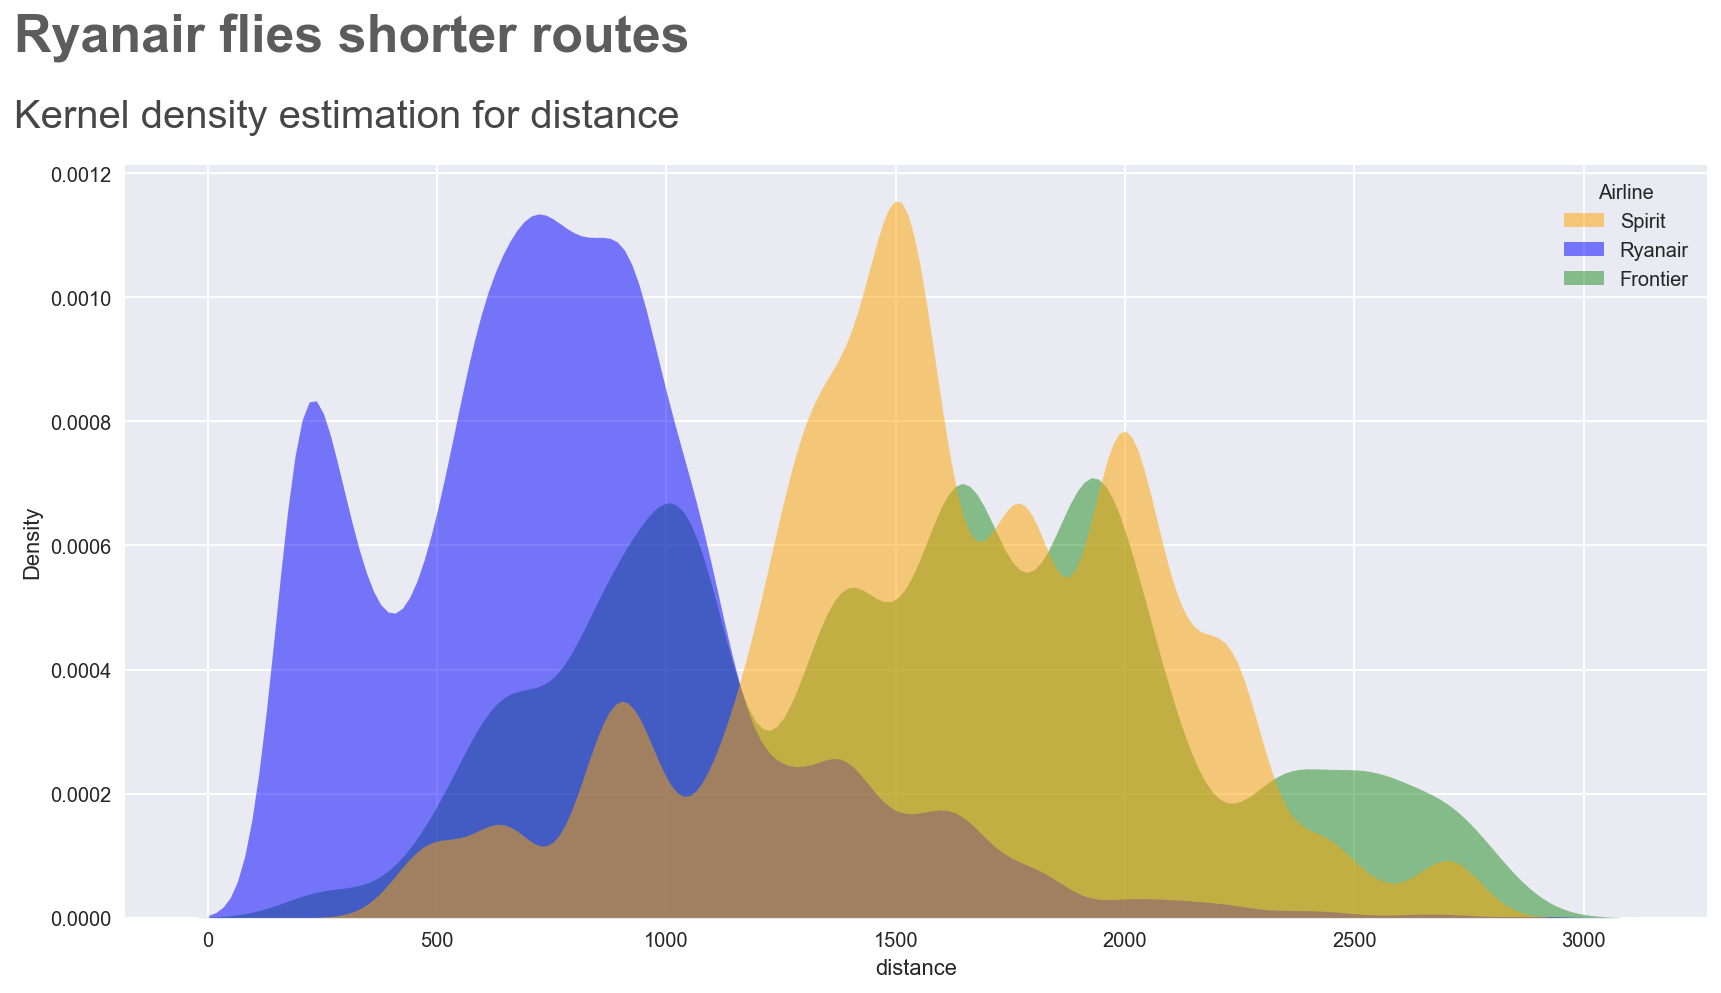

In [13]:
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(nrows=1, ncols=1, wspace=0, hspace=0)

ax = fig.add_subplot(gs[:,:])
x, y = align_with_axis(ax)

sns.kdeplot(
   data=df, x='distance', hue='Airline', ax=ax,
   fill=True, common_norm=False, palette=palette,
   alpha=.5, linewidth=0,
)

title='Ryanair flies shorter routes'
subtitle = 'Kernel density estimation for distance'
create_title_and_subtitle(ax, title=title, subtitle=subtitle)
fig.tight_layout()


In [14]:
import plotly.express as px
fig = px.histogram(df, x="distance", color='Airline', color_discrete_map=palette, opacity=.5, nbins=28, width=800, height=400,)# title_text='Ryanair flies more frequently')
fig.update_layout(margin=dict(l=20, r=20, t=35, b=15), title_text='Ryanair flies more frequently')
fig.show()

Taking a look at future flights...

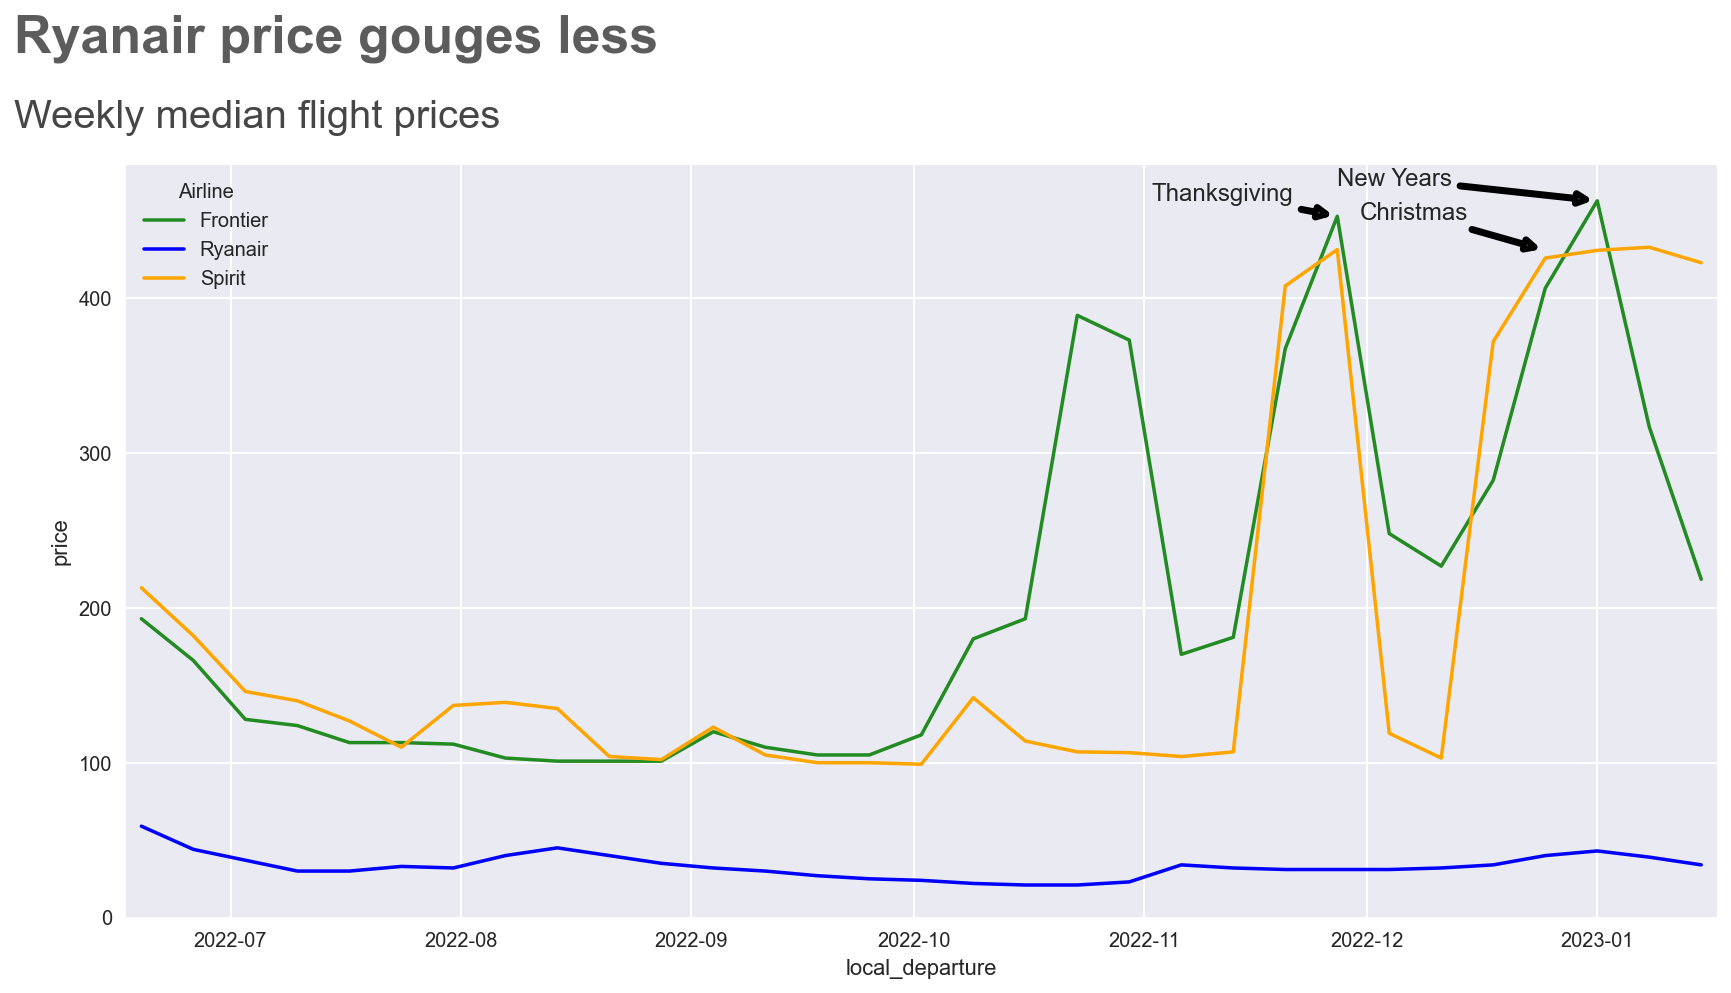

In [15]:
# Create df_fut by resampling df by week of departure date and taking the mean
df_fut = df.groupby('Airline').resample('W', on='local_departure').median()
n_most_expensive = df_fut.droplevel(0)['price'].nlargest(10)

fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(nrows=1, ncols=1, wspace=0, hspace=0)

ax = fig.add_subplot(gs[:,:])
ax.set_ylim(0, 1.05*n_most_expensive.values[0])

ax.annotate(
            'New Years', fontsize=12,
            xy=(mdates.date2num(n_most_expensive.index[0]), n_most_expensive.values[0]),
            xytext=(mdates.date2num(n_most_expensive.index[0])-35, n_most_expensive.values[0]+10),
            textcoords='data', arrowprops=dict(arrowstyle='-|>', lw=3.5)
            )

ax.annotate(
            'Thanksgiving', fontsize=12,
            xy=(mdates.date2num(n_most_expensive.index[1]), n_most_expensive.values[1]),
            xytext=(mdates.date2num(n_most_expensive.index[1])-25, n_most_expensive.values[1]+10),
            textcoords='data', arrowprops=dict(arrowstyle='-|>', lw=3.5)
            )

ax.annotate(
            'Christmas', fontsize=12,
            xy=(mdates.date2num(n_most_expensive.index[5]), n_most_expensive.values[4]),
            xytext=(mdates.date2num(n_most_expensive.index[5])-25, n_most_expensive.values[4]+20),
            textcoords='data', arrowprops=dict(arrowstyle='-|>', lw=3.5)
            )

ax.margins(0.01)

sns.lineplot(data=df_fut, x='local_departure', y='price', hue='Airline', palette=palette)
sns.move_legend(ax, 'upper left')

title = 'Ryanair price gouges less'
subtitle = 'Weekly median flight prices'
create_title_and_subtitle(ax, title=title, subtitle=subtitle)

fig.tight_layout()


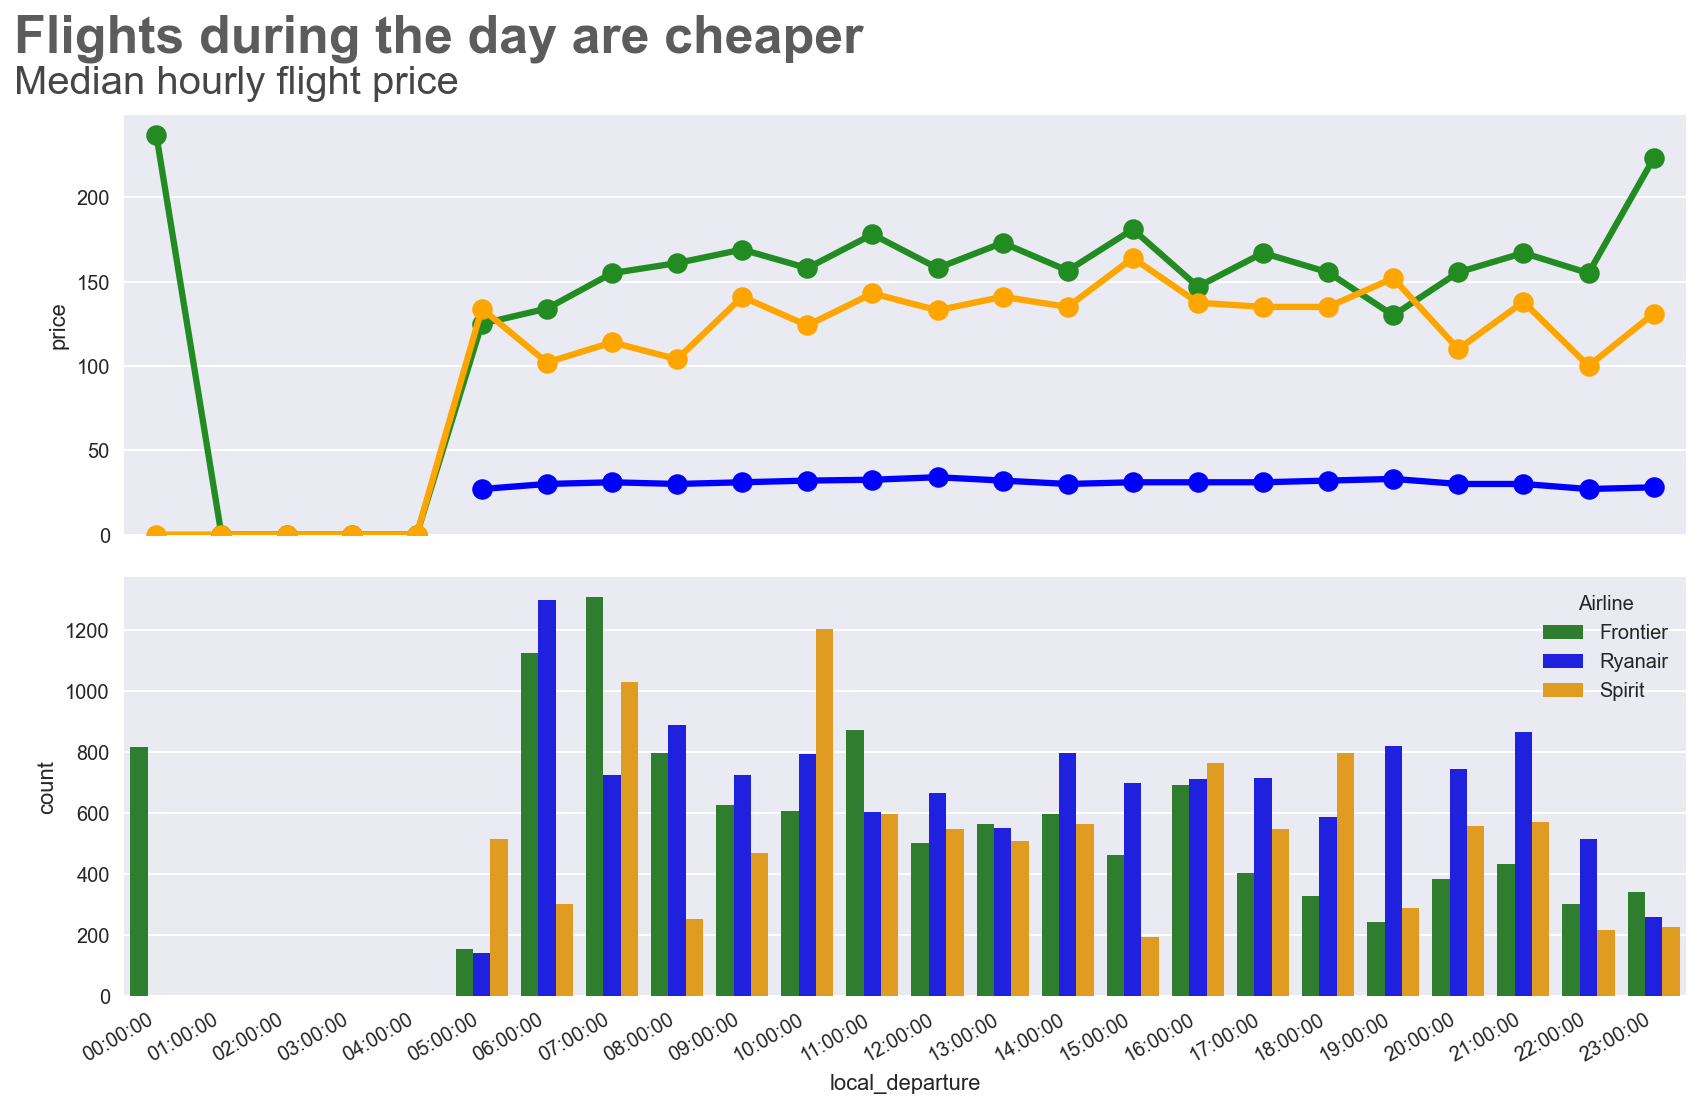

In [16]:
# Create hour by resampling df by week of departure date and taking the mean
df_hour = df.copy()
df_hour['local_departure'] = pd.to_datetime(df_hour['local_departure'].dt.time, format='%H:%M:%S')

#create a count df
count = df_hour.groupby('Airline').resample('60min', on='local_departure').count()['price']
df_hour = df_hour.groupby('Airline').resample('60min', on='local_departure').median()
df_hour['count'] = count

# want to filter out any hours with very small sample sizes
df_hour['count'] = df_hour['count'].where(count>=50, 0)
df_hour['price'] = df_hour['price'].where(df_hour['count']>=50, 0) 

# reset index and extract time
df_hour = df_hour.reset_index()
df_hour['local_departure'] = df_hour['local_departure'].dt.time
df_hour = df_hour.fillna(0)

fig = plt.figure(figsize=(14, 9))
gs = gridspec.GridSpec(nrows=2, ncols=1, wspace=0, hspace=.1)

ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:], sharex=ax1)

ax1.margins(0.01)
ax1.set_ylim(0, df_hour['price'].values.max()*1.05)

sns.pointplot(data=df_hour.reset_index(), x='local_departure', y='price', hue='Airline', ax=ax1, palette=palette,)
sns.barplot(data=df_hour, x='local_departure', y='count', hue='Airline', ax=ax2, palette=palette, linewidth=0, )

ax1.legend_.remove()

title='Flights during the day are cheaper'
subtitle = 'Median hourly flight price'
create_title_and_subtitle(ax1, title=title, subtitle=subtitle)

fig.autofmt_xdate()
fig.fmt_xdata = mdates.DateFormatter('%H:%M:%S')


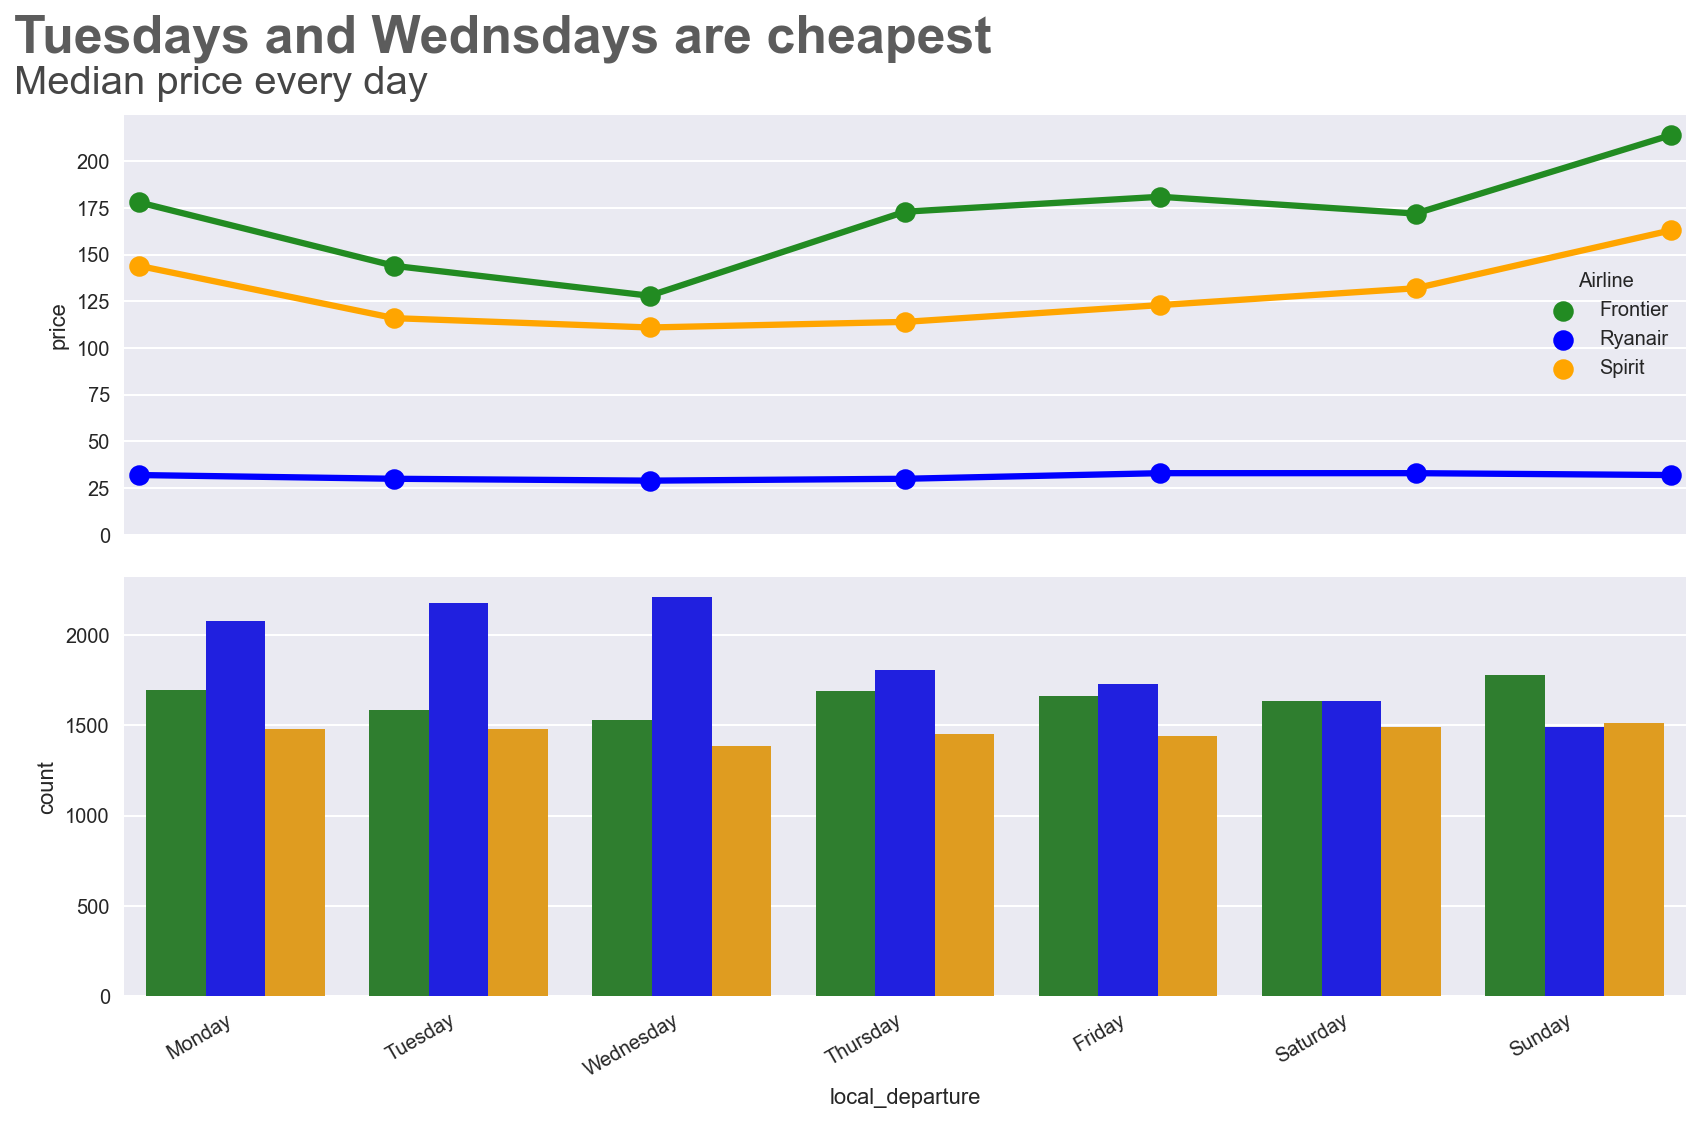

In [17]:
df['local_departure'].dt.weekday

import datetime
# Create df_fut by resampling df by week of departure date and taking the mean
df_wkd = df.copy()
df_wkd['local_departure'] = df['local_departure'].dt.day_name()

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_wkd['local_departure'] = pd.Categorical(df_wkd['local_departure'], categories=days, ordered=True)
df_wkd = df_wkd.sort_values('local_departure')


#create a count df
count = df_wkd.groupby(['Airline', 'local_departure']).count()['price']
df_wkd = df_wkd.groupby(['Airline', 'local_departure']).median()
df_wkd['count'] = count
df_wkd = df_wkd.reset_index()

fig = plt.figure(figsize=(14, 9))
gs = gridspec.GridSpec(nrows=2, ncols=1, wspace=.1, hspace=.1)

ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])

x, y = align_with_axis(ax1)

ax1.set_ylim(0, df_wkd['price'].values.max()*1.05)
times = [datetime.datetime.strptime(str(i), '%H') for i in range(24)]

sns.pointplot(data=df_wkd.reset_index(), x='local_departure', y='price', hue='Airline', ax=ax1, palette=palette,)
sns.barplot(data=df_wkd, x='local_departure', y='count', hue='Airline', ax=ax2, palette=palette,)

ax2.legend_.remove()
title='Tuesdays and Wednsdays are cheapest'
subtitle = 'Median price every day'
create_title_and_subtitle(ax1, title=title, subtitle=subtitle)

ax1.margins(0.01)
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%H:%M:%S')

It might be useful to compare prices of flights out of bases and not.

In [18]:
bases_df = pd.concat([
                      spirit_dest[spirit_dest['Refs'].str.contains('Base')],
                      frontier_dest[frontier_dest['Notes'].str.contains('Base')],
                      ryanair_dest[ryanair_dest['Notes'].str.contains('Base')]
                      ])
df_b = df[(df['flyFrom'].isin(bases_df['iata']) | df['flyFrom'].isin(bases_df['iata']))] # flights out of bases
df_nb = df[~(df['flyFrom'].isin(bases_df['iata']) | df['flyFrom'].isin(bases_df['iata']))] # flights not out of bases

df_b.loc[:, 'Base'] = 'Base'
df_nb['Base'] = 'Not_Base'

df = pd.concat([df_b, df_nb])


Api docs definition of quality. 

quality: Exact details are subject to internal logic. Use it if you want to sort your flights according to quality. The lower the number the better.

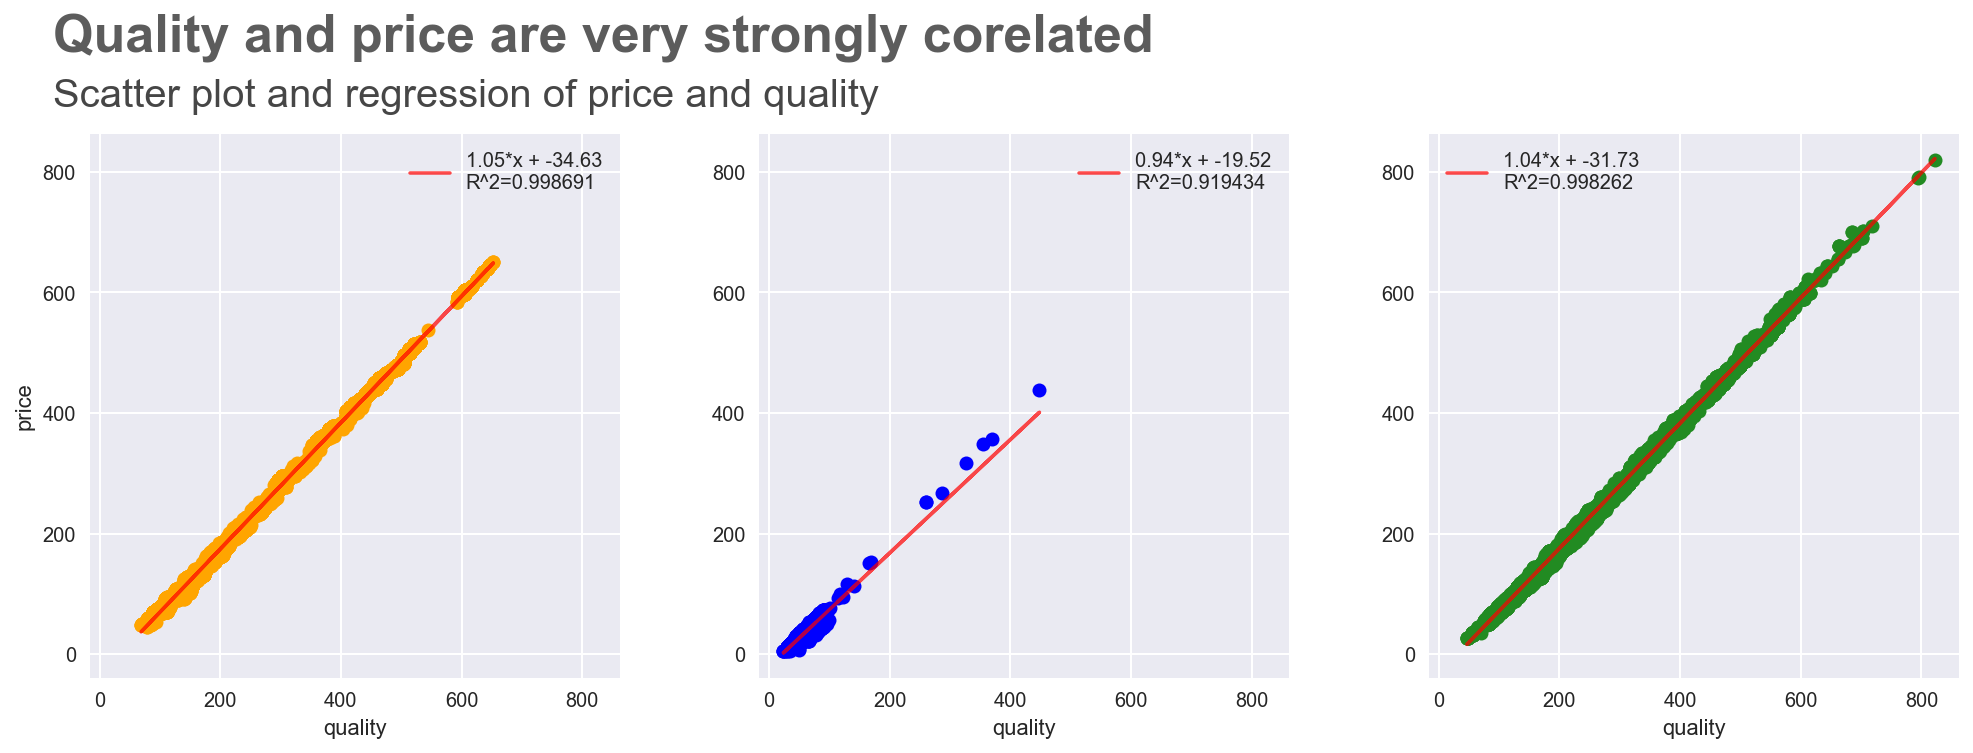

In [19]:
from math import ceil
from scipy.stats import linregress
airlines = ['Spirit', 'Ryanair', 'Frontier']
matrices = [df[df['Airline']==airline] for airline in airlines]

fits = {}
for matrix in matrices:
    x = matrix['quality']
    y = matrix['price']
    res = linregress(x, y)
    fits[matrix['Airline'].values[0]] = res

N = len(airlines)
cols = 3
rows = ceil(N / cols)

gs = gridspec.GridSpec(rows, cols, wspace=0)
fig = plt.figure(figsize=(18, 5))

i = 0
for fit in fits.keys():
    # calculate fit vals
    df_fit = df[df['Airline']==fit]
    x_vect, y_vect = df_fit.quality.values, df_fit.price.values
    reg = fits[fit]
    y_fit = reg.slope*x_vect+reg.intercept

    if i <= 0:
        ax_before = None
    else:
        ax_before = fig.axes[-1]
    
    ax = fig.add_subplot(gs[i], sharex=ax_before, sharey=ax_before)

    if i<=0:
        ax.set_ylabel('price')
        title='Quality and price are very strongly corelated'
        subtitle = 'Scatter plot and regression of price and quality'
        create_title_and_subtitle(ax, title, subtitle)

    ax.plot(x_vect, y_fit, color='r', label='{:.2F}*x + {:.2F}\nR^2={:6F}'.format(reg.slope, reg.intercept, reg.rvalue**2), alpha=.7)
    ax.scatter(x_vect, y_vect, color=palette[list(palette.keys())[i]], edgecolors='w', linewidths=0)
    
    ax.set_xlabel('quality')
    ax.legend(loc='best')
    ax.set_aspect('equal', adjustable='box')

    i += 1


The regressions above are very accurate. So a price prediction can accurately be made if quality can be calculated.

Lets look at per kilometer pricing

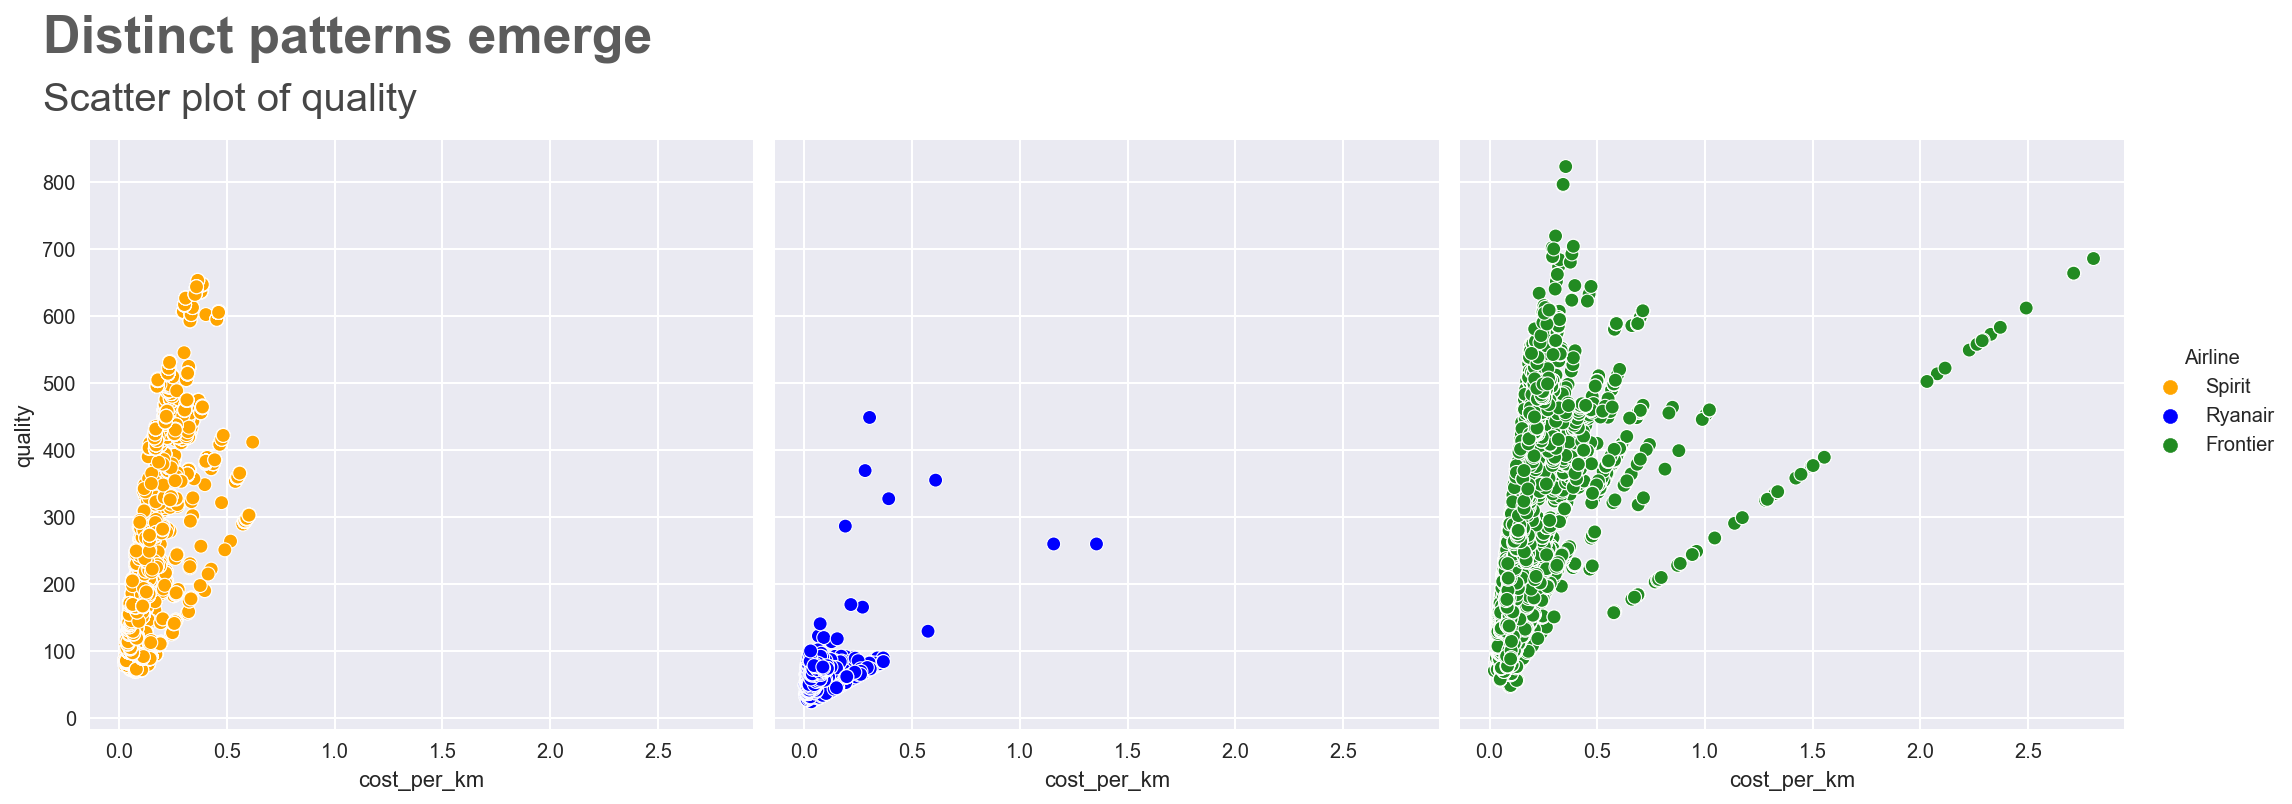

In [20]:
fig = sns.relplot(
        data=df, x='cost_per_km', y='quality',
        col='Airline', hue='Airline', palette = palette, kind='scatter'
)

title='Distinct patterns emerge'
subtitle = 'Scatter plot of quality'
axs = fig.axes
i = 0
for col in axs:
    for ax in col:
        if i == 0:
                create_title_and_subtitle(ax, title=title, subtitle=subtitle)
        ax.set_title('')
        i += 1


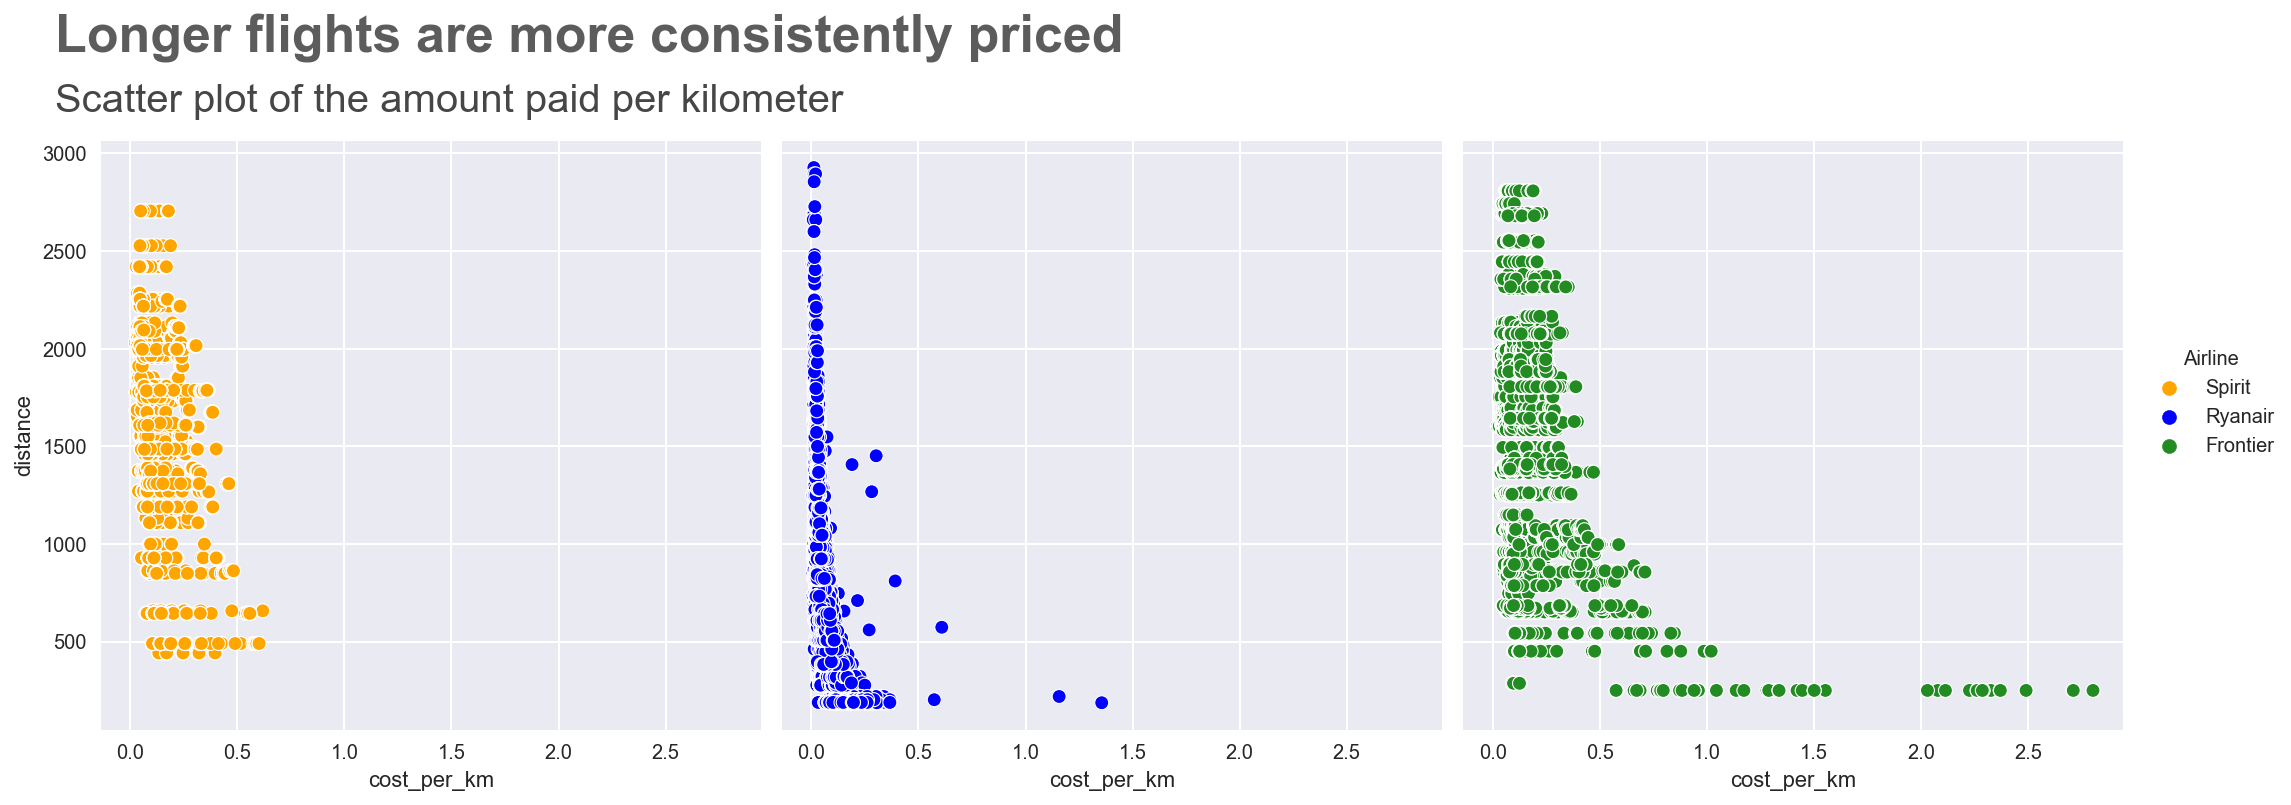

In [21]:
fig = sns.relplot(
        data=df, x='cost_per_km', y='distance',
        col='Airline', hue='Airline', palette = palette, kind='scatter'
)

title='Longer flights are more consistently priced'
subtitle = 'Scatter plot of the amount paid per kilometer'

axs = fig.axes
i = 0
for col in axs:
    for ax in col:
        if i == 0:
                create_title_and_subtitle(ax, title=title, subtitle=subtitle)
        ax.set_title('')
        i += 1

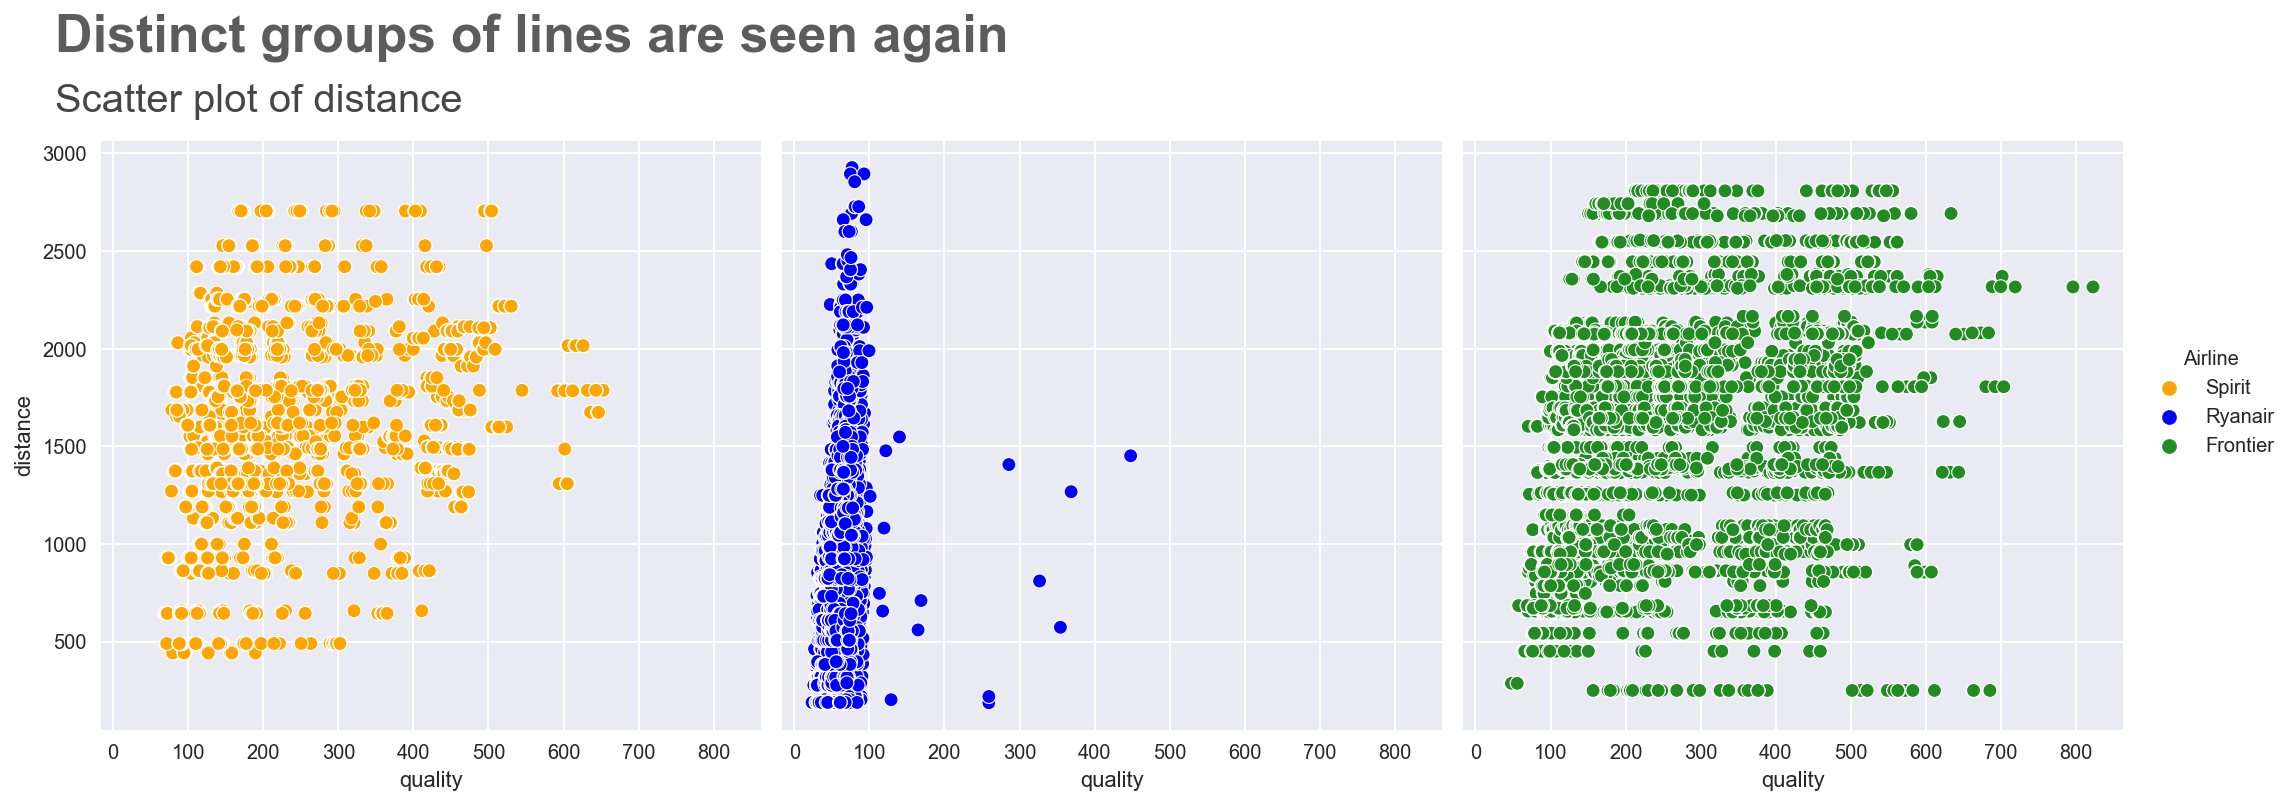

In [22]:
fig = sns.relplot(
        data=df, x='quality', y='distance',
        col='Airline', hue='Airline', palette=palette, kind='scatter'
)

title='Distinct groups of lines are seen again'
subtitle = 'Scatter plot of distance'

axs = fig.axes
i = 0
for col in axs:
    for ax in col:
        if i == 0:
                create_title_and_subtitle(ax, title=title, subtitle=subtitle)
        ax.set_title('')
        i += 1

There seem to be "bands" of values for all three airlines. Quality vs cost_per_km could be made up of a bunch of differen't lines. Distance and cost_per_km could be made of a bunch of different log functions bound by a lower limit.

## III) Modeling

We can see that the price paid for every kilometer (cpk) is linearly related to the quality (q). There appear to be distinct "lines" of data which can be modeled using: $$cpk = m\cdot q+b \tag{1}$$

Similarly, cpk can be modeled using $$cpk = a\cdot e^{c\cdot d} \tag{2}$$

Rearanging variables $$q = (a\cdot e^{c\cdot d}-b)/m \tag{3}$$

c, m, a, and b are all likely functions of airport. Revisit

In [23]:
# we will use scipy to find best fit parameters and np.exp
# probably has something to do with time of day/where you depart from. Revisit

from numpy import exp
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * exp(-b * x) + c